## Introduction

In this notebook, we will explore some fundamental methods for extracting features. Specifically, we will use the term "**features**" to refer to the various attributes used to describe and classify segments in an image.

Once segments have been created in an image (as we did in the previous notebook), the next crucial step is to characterize these segments in a way that captures their meaningful properties. The strength of **Object-Based Image Analysis (OBIA)** lies in its ability to use various features to characterize segments, extending beyond simple spectral properties. Features such as shape, texture, and contextual characteristics can greatly enhance the classification of these segments.

Extracting features in Python requires aggregating pixel information for each segment. There are various ways to achieve this. In Python, the `regionprops()` function from the [skimage](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table) library can be used as it comes with several pre-implemented features.

## **Setup**

Please run the cell below. After that, go to **Runtime -> Restart session**, and confirm. Once the session restarts, move on to the next cell **without running this one again**.

In [ ]:
# Check if running on Google Colab
if 'google.colab' in str(get_ipython()):
    import os
    repo_dir = "obia_tutorials"
    marker_file = os.path.join(repo_dir, ".setup_done")

    # Setup the environment only if it hasn't been done already
    if not os.path.exists(marker_file):
        # Clone the repository
        !git clone https://github.com/mariarodriguezn/obia_tutorials.git

        # Install the required packages
        !pip install -r obia_tutorials/requirements.txt

        # Create a marker file to avoid re-running the setup
        with open(marker_file, 'w') as f:
            f.write("Setup completed")

In [1]:
# imports
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import rasterio

from scipy import stats
from skimage.color import label2rgb
from skimage.measure import regionprops, regionprops_table
from skimage.segmentation import mark_boundaries, slic
from skimage.util import map_array
from tqdm import tqdm

## **Exemplary data**

In this notebook, we will continue working with the same high-resolution image used in the first notebook of this series. This image contains four spectral bands: Red, Green, Blue, and Near-Infrared (NIR). Additionally, we will utilize the Normalized Difference Vegetation Index (NDVI) that was calculated from these bands.

Our analysis will begin with a segmentation process using the Simple Linear Iterative Clustering (SLIC) algorithm, which was also introduced in the first notebook. Specifically, we will use a compactness value of 0.3 and set the number of superpixels to 3000. This segmentation will help us divide the image into manageable segments, which we will then characterize using various features.

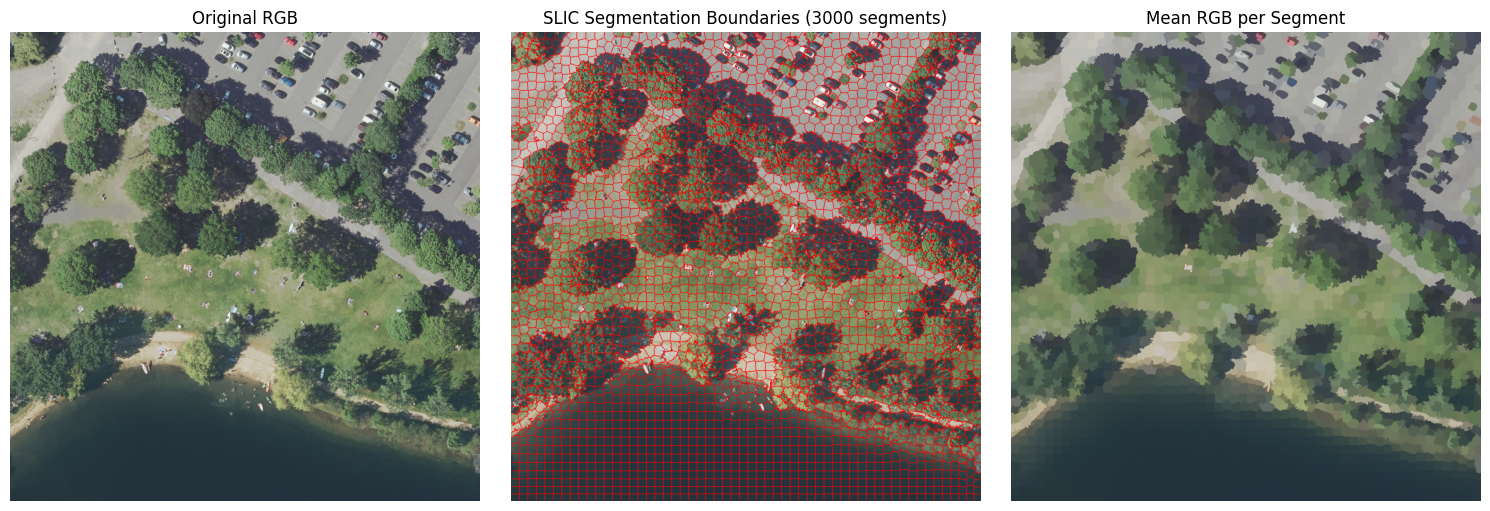

In [2]:
# File path to the image
img_path = "obia_tutorials/sample_data/ortho_subset_I.tif"

# Read the image and extract the bands
with rasterio.open(img_path) as src:
    # Extract red, green, blue, and NIR bands, normalize to [0, 1]
    bands = src.read([1, 2, 3, 4]).astype(float) / 255
    red, green, blue, nir = bands

# Stack RGB into an array
rgb = np.stack([red, green, blue], axis=-1)

# Calculate NDVI
ndvi = (nir - red) / (nir + red + 1e-6)  # small value added to avoid division by zero

# Stack all bands into an array
image = np.stack([red, green, blue, nir], axis=-1)

# Set the fixed compactness and number of superpixels
compactness = 0.3
n_segments = 3000

# Generate segments using SLIC
segments = slic(image, n_segments=n_segments, compactness=compactness, start_label=1)

# Create the figure with 3 subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)

# Display the original RGB image
axs[0].imshow(rgb)
axs[0].set_title("Original RGB")

# Display the RGB image with segmentation boundaries for 3000 segments
axs[1].imshow(mark_boundaries(rgb, segments, color=(1, 0, 0), mode="thick"))
axs[1].set_title(f"SLIC Segmentation Boundaries ({n_segments} segments)")

# Display the mean RGB per segment
axs[2].imshow(label2rgb(segments, rgb, kind='avg'))
axs[2].set_title("Mean RGB per Segment")

# Remove axis for all subplots
for ax in axs:
    ax.set_axis_off()

# Display the combined figure
plt.show()

From executing the next two cells, we can observe two key points:

1.   **Image Details**: The image has a resolution of 1500x1500 pixels and contains four spectral bands: Red, Green, Blue, and Near-Infrared (NIR). This high resolution allows us to explore the scalability of the feature extractions. To facilitate this, a **decorator** will be used to measure the execution time of certain functions defined later on.

2.    **Segmentation Results**: The resulting segments (2957) from the SLIC method are slightly fewer than the target number of superpixels (3000) selected. This is expected because the SLIC algorithm balances color similarity with spatial proximity, sometimes merging or adjusting segments to maintain coherence, especially in areas with less distinct boundaries. As a result, the final number of segments may be slightly lower than the requested number.


In [3]:
# Print basic information on image & segmentation
print(f"Image shape: {image.shape}")
print(f"Number of segments: {len(np.unique(segments))}")

Image shape: (1500, 1500, 4)
Number of segments: 2957


In [4]:
# Decorator for timing
def timeit(method):
    def timed(*args, **kw):
        tstart = time.perf_counter()
        result = method(*args, **kw)
        tend = time.perf_counter()
        total_ms = (tend - tstart)
        print(f"Execution time: {total_ms:.2f}s")
        return result
    return timed

## **Types of features**

### **I. Spectral features**

Spectral features capture the radiometric properties of segments by analyzing pixel values across different spectral bands. In this tutorial we've focused on the **intensity mean** and **standard deviation** spectral features.

#### **I. Intensity Mean**

 The intensity mean represents the average spectral value for each band within a segment. This value is crucial as it provides a summary statistic of the segment's radiometric properties, which can be used for further classification or analysis.

In the code below, by using the `regionprops_table` function from the [skimage.measure](https://scikit-image.org/docs/stable/api/skimage.measure.html) module we compute the intensity mean values for each segment across the different bands (Red, Green, Blue, and NDVI).

In [7]:
# Define intensity mean calculation function
@timeit
def calc_mean(seg_arr, img_arr):
    spec_feats = regionprops_table(
        label_image = seg_arr, # Segmented image
        intensity_image = img_arr, # Image stack (R, G, B, NDVI)
        properties = ["label", "intensity_mean"] # Calculate intensity mean per band
        )
    return pd.DataFrame(spec_feats)

# Perform calculation
means = calc_mean(segments, np.dstack([rgb, ndvi]))

# Sort the table by intensity_mean-3 in ascending order
means_sorted = means.sort_values(by="intensity_mean-3", ascending=True)

display(means)

Execution time: 0.97s


,label,intensity_mean-0,intensity_mean-1,intensity_mean-2,intensity_mean-3
0,1,0.604319,0.625089,0.583083,0.039661
1,2,0.359322,0.392994,0.320563,0.288713
2,3,0.441907,0.489653,0.374884,0.253889
3,4,0.234354,0.266893,0.268920,0.421836
4,5,0.205337,0.234459,0.260040,0.406761
...,...,...,...,...,...
2952,2953,0.140090,0.206220,0.241319,0.222641
2953,2954,0.141707,0.208822,0.243838,0.224049
2954,2955,0.143506,0.209567,0.246361,0.217008
2955,2956,0.144446,0.210656,0.247117,0.215110


#####**Task 1**
Considering the NDVI mean (intensity_mean-3 in the table above) for each segment, discuss what range of values would you expect for segments corresponding to Water, Meadow, and Trees cover?


**Your answer goes here:**
\
I first sort the table by intensity_mean-3 in ascending order. We see that the range of NDVI values is from 0.03 to 0.2.
\
Water bodies would likely have the lowest NDVI values, ranging from 0.03 to 0.1, meadows would occupy the middle range from 0.1 to 0.15, and trees would show the highest NDVI values from 0.15 to 0.2.

Now, let's see how the mean NDVI is distributed within each segment. On the left, we have the original RGB image with the SLIC segment boundaries, and on the right, the mean NDVI values are displayed for each segment.

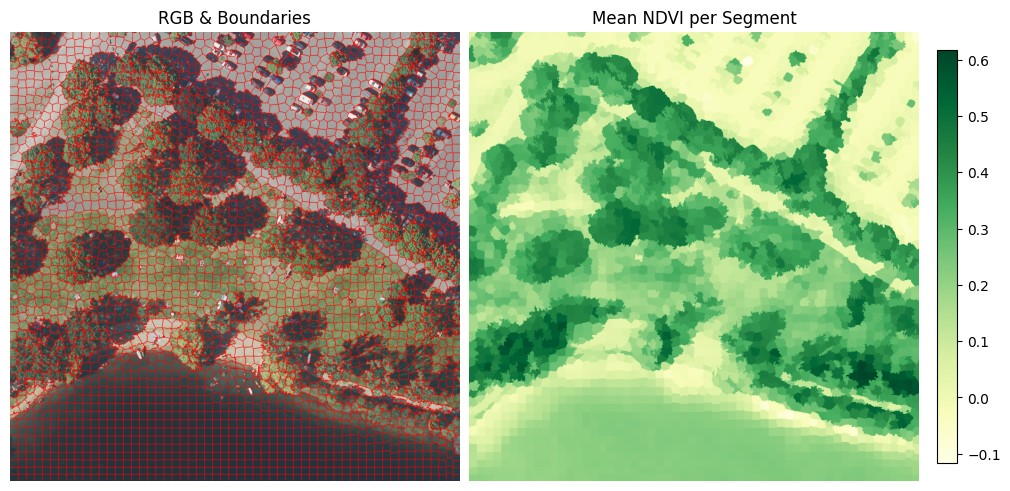

In [6]:
# Mapping NDVI mean values back to image segments
mapped_mean = map_array(
    segments,
    np.array(means["label"]),
    np.array(means["intensity_mean-3"])
)

# Visualize the results
fig, axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)
axs[0].imshow(mark_boundaries(rgb, segments, (1,0,0), mode="thick"))
im = axs[1].imshow(mapped_mean, cmap="YlGn")
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

axs[0].set_title("RGB & Boundaries")
axs[1].set_title("NDVI per Pixel")
axs[1].set_title("Mean NDVI per Segment")


for ax in axs.flat:
    ax.set_axis_off()

plt.show()


#### **II. Standard Deviation**

Standard deviation is a statistical measure that tells how much the values within a segment vary from the mean. In the context of image analysis, calculating the standard deviation for each segment can provide insights into the homogeneity or variability of the segment's pixel values. For example, a low standard deviation in an NDVI segment might indicate uniform vegetation health, while a high standard deviation could suggest a mix of healthy and stressed vegetation within that segment.

To calculate the standard deviation for each segment, we can create a custom function using the `extra_property` parameter in `regionprops`. The function uses a `regionmask`, which identifies the pixels belonging to the segment and calculates their standard deviation.

The following example demonstrates how to use the `extra_property` parameter in regionprops to calculate the standard deviation of pixel values within each segment for the Red, Green, Blue, and NDVI bands.

#####**Task 2**
Complete the code below to perform the calculation of the Standard Deviation for each segment (stds).

**Hint**: The code structure is the same as the one used for calculating the mean before, but this time you must use the *calc_std* function

In [ ]:
# Define a custom function to calculate the standard deviation for each segment
def std(regionmask, intensity_img):
    vals = intensity_img[regionmask]
    std = np.std(vals)
    return std

@timeit

# Define a function to calculate standard deviation for all segments
def calc_std(seg_arr, img_arr):
    spec_feats = regionprops_table(
        label_image = seg_arr,
        intensity_image = img_arr,
        properties = ["label",],
        extra_properties=(std,)
        )
    return pd.DataFrame(spec_feats)

#### Your code here to Perform the stds calculation *****
stds =


Now, let's explore how the standard deviation of NDVI values is distributed within each segment. On the left, we have the original RGB image with the SLIC segment boundaries, and on the right, the standard deviation of NDVI values is displayed for each segment.

In [ ]:
# Map the standard deviation of NDVI values back to image segments
mapped_std = map_array(
    segments,
    np.array(stds["label"]),
    np.array(stds["std-3"])
)

# Visualize the RGB image with segment boundaries and the standard deviation of NDVI
fig, axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)

# Display the original RGB image with segment boundaries
axs[0].imshow(mark_boundaries(rgb, segments, (1,0,0), mode="thick"))
axs[0].set_title("RGB & Boundaries")

# Display the standard deviation of NDVI per segment with the 'viridis' colormap
im = axs[1].imshow(mapped_std, cmap="viridis")
axs[1].set_title("Standard Deviation of NDVI per Segment")
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

# Remove axis for both subplots
for ax in axs.flat:
    ax.set_axis_off()

# Show the plots
plt.show()


### **II. Shape features**

In addition to spectral features, **shape features** provide valuable information about the form and structure of segments, which can be critical in applications such as object recognition, land cover classification, and more.

Common shape features include **rectangularity**, **compactness**, and **solidity**, which we've focused on in this tutorial. Other useful shape features include elongation, which measures how stretched or elongated a segment is, and circularity, which assesses how close the shape of a segment is to a perfect circle.


#### **I. Rectangularity**

Rectangularity is a measure of how closely the shape of a segment approximates a rectangle. It is defined as the ratio between the segment's area and the area of its bounding box. A segment that perfectly fills its bounding box will have a rectangularity value of 1, while segments that are more irregularly shaped will have lower values.

Here’s how we can calculate rectangularity:

In [ ]:
# Define a custom function to calculate the rectangularity of each segment
def rectangularity(regionmask):
    return regionmask.sum()/regionmask.size

@timeit
# Define a function to calculate rectangularity for all segments
def calc_rect_shapes(seg_arr):
    shp_feats = regionprops_table(
        label_image = seg_arr,
        properties = ["label", "area_bbox"],
        extra_properties=(rectangularity,)
        )
    return pd.DataFrame(shp_feats)

# Perform the rectangularity calculation for each segment and display the results
rects = calc_rect_shapes(segments)
display(rects)

Now, let's explore how the rectangularity of segments is distributed across the image. On the left, we have the original RGB image with the segment boundaries clearly defined, and on the right, we will map and display the rectangularity values for each segment.

In [ ]:
# Map rectangularity values back to the image segments
mapped_rectangularity = map_array(
    segments,
    np.array(rects["label"]),            # Segment labels
    np.array(rects["rectangularity"])    # Rectangularity values
)

# Visualize the RGB image with segment boundaries and rectangularity
fig, axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)

# Display the original RGB image with segment boundaries
axs[0].imshow(mark_boundaries(rgb, segments, (1,0,0), mode="thick"))
axs[0].set_title("RGB & Boundaries")

# Display the rectangularity per segment
im = axs[1].imshow(mapped_rectangularity, cmap="viridis")
axs[1].set_title("Rectangularity per Segment")
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

# Remove axis for both subplots
for ax in axs.flat:
    ax.set_axis_off()

# Show the plots
plt.show()


#####**Task 3**
Do you consider that the rectangularity will be the same if we rotate the objects in the image (e.g. Rotating a segment which delinates a car)?

**You answer goes here:**

#### **II. Compactness & Solidity**

*   **Compactness** quantifies how closely a segment's shape resembles a circle. High compactness indicates a circular shape, while lower values suggest more elongated or irregular shapes. This metric is useful for distinguishing between objects with similar areas but different shapes, such as circular ponds versus irregular river sections.

  It is calculated using the formula:

  \begin{equation}
  \text{Compactness} = \frac{4 \times \pi \times \text{Area}}{\text{Perimeter}^2}
  \end{equation}


*  **Solidity** measures how "solid" or "filled" a shape is by comparing the segment’s area to its convex hull (the smallest convex shape that can enclose the segment). High solidity suggests a solid shape with few indentations, while lower values indicate shapes with significant gaps or concavities.

  It is calculated using the formula:
  \begin{equation}
  \text{Solidity} = \frac{\text{Area of the Segment}}{\text{Area of the Convex Hull}}
  \end{equation}



In [ ]:
# Define a function to calculate shape features, including compactness and solidity
@timeit
def calc_shapes(seg_arr, solidity=True):
    if solidity:
        props = ["label", "solidity", "area", "perimeter"]
    else:
        props = ["label", "area", "perimeter"]
    shp_feats = regionprops_table(
        label_image = seg_arr,
        properties = props,
        )
    compactness = 4*np.pi*shp_feats["area"]/(shp_feats["perimeter"]**2)
    shp_feats["compactness"] = compactness
    shp_feats.pop("area")
    shp_feats.pop("perimeter")
    return pd.DataFrame(shp_feats)

# Perform the shape calculations and display the results
shapes = calc_shapes(segments)
display(shapes)

Calculating the convex hull image for solidity can be computationally demanding (as evidenced in the cell below), especially when working with large datasets. Because of this, compactness is often a better choice when processing speed is important.

In [ ]:
# Compare timing between Compactness and Solidity calculations
print("Solidity & Compactness")
_ = calc_shapes(segments)

print(f"\nCompactness")
_ = calc_shapes(segments, solidity=False)

Let's check below how compactness and solidity values are distributed within each segment.

In [ ]:
# Map compactness and solidity values back to their corresponding segments in the image
mapped_compactness = map_array(segments, np.array(shapes["label"]), np.array(shapes["compactness"]))
mapped_solidity = map_array(segments, np.array(shapes["label"]), np.array(shapes["solidity"]))

#Display Original RGB, Compactness, and Solidity
fig, axs = plt.subplots(ncols=3, figsize=(15,10), constrained_layout=True)
axs[0].imshow(mark_boundaries(rgb, segments, (1,0,0), mode="thick"))
im1=axs[1].imshow(mapped_compactness, vmin = 0, vmax=1)
im2=axs[2].imshow(mapped_solidity, vmin = 0, vmax=1)
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

axs[0].set_title("RGB & Boundaries")
axs[1].set_title("Compactness")
axs[2].set_title("Solidity")

for ax in axs.flat:
    ax.set_axis_off();

# Show the plots
plt.show()

#####**Task 4**
Considering the timings and the visual results for the Compactness and Solidity shape features, which one do you think better distinguishes vegetation from non-vegetation segments?

**You answer goes here:**

### **III. Textural features**

Textural features are essential for analyzing the surface characteristics and patterns within an image. They are well-known for their ability to capture patterns based on the relationships between neighboring pixels. In this section, we will focus on a simple yet powerful textural feature: **entropy**.

#### **I. Entropy**

Entropy measures the degree of randomness or disorder in the pixel intensity values within a segment. High entropy values indicate a high level of complexity and variation, such as in areas with mixed vegetation types. Conversely, low entropy values suggest more uniform and homogenous areas, like open fields or water bodies.

In the following section, we will calculate and visualize the entropy of NDVI values within each segment.

In [ ]:
# Function to calculate entropy for NDVI values within each segment
def entropy_ndvi(regionmask, intensity_img):
    vals = intensity_img[regionmask]
    arr = stats.relfreq(vals, 100, defaultreallimits=(-1,1))[0]
    return stats.entropy(arr)

@timeit
# Define a function to calculate entropy for all segments
def calc_entropy(seg_arr, img_arr):
    entropy_feats = regionprops_table(
        label_image = seg_arr,
        intensity_image = img_arr,
        properties = ["label"],
        extra_properties = (entropy_ndvi,)
        )
    return pd.DataFrame(entropy_feats)

# Perform the entropy calculation and display the results
entropy = calc_entropy(segments, ndvi)
display(entropy)

In [ ]:
# Visualise results
mapped_entropy = map_array(segments, np.unique(segments), np.array(entropy["entropy_ndvi"]))

fig, axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)
axs[0].imshow(mark_boundaries(rgb, segments, (1,0,0), mode="thick"))
axs[0].set_title("RGB & Boundaries")

im=axs[1].imshow(mapped_entropy)
axs[1].set_title("Entropy")
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

for ax in axs.flat:
    ax.set_axis_off();

#####**Task 5**
Based on the Entropy image, which class(es) do you think can be easily identified, and why?

**You answer goes here:**

## **Conclusion & Further thoughts**

This tutorial has demonstrated how to calculate and visualize a variety of features, each offering different insights into the segmented regions of an image. The choice of features depends on the segmentation technique used and the specific application at hand. Key considerations when selecting features include:

*   **Interpretability of features** - Some features, like compactness, offer intuitive insights, while others may require more in-depth understanding to interpret correctly.
*   **Scalability of calculations** - As datasets grow larger, especially in the context of big data, it becomes increasingly important to choose descriptors that are computationally efficient.